<a href="https://colab.research.google.com/github/kaggler-KyotoUni/kaggle-m5forecasting/blob/chopprin_branch/lightGBM_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%load_ext autoreload
import pandas as pd 
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import numpy as np 

import matplotlib.pyplot as plt 
plt.rc('figure',figsize=[10.0, 3.0])

import seaborn as sns; sns.set()
import os
import glob
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

from itertools import cycle
pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

# メモリ解放の為
import gc

from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf 
tf.__version__

# データは1回しか読み込みしなくてもgoogle colab上に移したほうが速いとの事
!mkdir "/content/data/"
!cp -r "/content/drive/My Drive/kaggle/data/m5-forecasting" "/content/data/" 
# moduleはgoogle driveにおいとく
# !mkdir "/content/module/"
# !cp -r "/content/drive/My Drive/kaggle/module" "/content/module/"

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/content/data/’: File exists


In [3]:
!ls

data  drive  sample_data


In [4]:
%autoreload
%cd "/content/drive/My Drive/kaggle/module/"
import load_data as ld
import eda_data as ed

/content/drive/My Drive/kaggle/module


In [25]:
cal, stv, ste, ss, sellp = ld.read_data("/content/data/m5-forecasting/")
print("Read finished")
print("@@@@@@@@@@@@@@@@@@")

csv_list = [cal, stv, ss]
#csv_list = [cal, stv, ste, ss, sellp]

for i, csv in enumerate(tqdm(csv_list)):
    csv_list[i] = ld.reduce_mem_usage(csv)
print("Memory usage reduced")
print("@@@@@@@@@@@@@@@@@@")

  0%|          | 0/3 [00:00<?, ?it/s]

Read finished
@@@@@@@@@@@@@@@@@@
Mem. usage decreased to  0.12 Mb (41.9% reduction)


100%|██████████| 3/3 [02:02<00:00, 40.92s/it]

Mem. usage decreased to 95.00 Mb (78.7% reduction)
Mem. usage decreased to  2.09 Mb (84.5% reduction)
Memory usage reduced
@@@@@@@@@@@@@@@@@@


In [26]:
for i, csv in enumerate(tqdm(csv_list)):
    csv_list[i] = csv.fillna(0)

100%|██████████| 3/3 [00:00<00:00, 17.25it/s]


In [7]:
# 1969日分 × イベントの情報14feature
print("calender shape : {}".format(cal.shape))

# wm_yr_wk違いで6841121個のデータ × sell_priceの情報4feature
print("sell_prices shape : {}".format(sellp.shape))

# 30490種類の商品　× 1919日のデータ 
print("sales_train_val shape : {}".format(stv.shape))

# 60980種類の商品 × 29日分のデータ
print("submission shape : {}".format(ss.shape))

calender shape : (1969, 14)
sell_prices shape : (6841121, 4)
sales_train_val shape : (30490, 1919)
submission shape : (60980, 29)


In [8]:
# 予測期間とitem数の定義 / number of items, and number of prediction period
NUM_ITEMS = stv.shape[0]  # 30490
DAYS_PRED = ss.shape[1] - 1  # 28

EDA
- ある日（x）まで売上が0の時がある
- x日以降も売れない日は存在する

In [9]:
nrows = 365 * 2 * NUM_ITEMS
nrows = 100

In [10]:
# tidy（整然）なテーブルにする
c = pd.melt(stv[0:nrows], id_vars = ["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"], var_name = "day", value_name = "demand")

In [11]:
# demandに欠損値はあるか
c["demand"].isnull().sum()

0

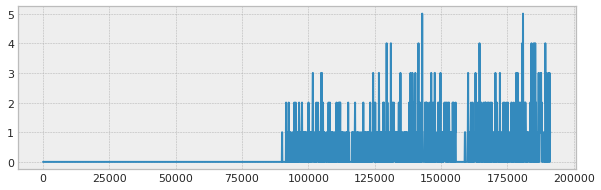

In [12]:
c[c["id"] == c["id"].unique()[0]]["demand"].plot()

validationとevaluationに分けて処理する
今回はvalidationはstvにくっつけて，evaluationの所は_validationという名前をつけて予測

In [13]:
product = stv[["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"]].drop_duplicates()

In [14]:
validation = [row for row in ss["id"] if "validation" in row]
test1_rows = ss["id"].isin(validation)

evaluation = [row for row in ss["id"] if "validation" in row]
test2_rows = ss["id"].isin(evaluation)

test1 = ss[test1_rows]
test2 = ss[test2_rows]

# 左結合は元データのtest側を重視
test1 = test1.merge(product, how = "left", on = "id")
test2 = test2.merge(product, how = "left", on = "id")

test2["id"] = test2["id"].str.replace("_evaluation", "_validation")

# 評価用のデータに対して商品の情報を与えてあげる
test1 = pd.melt(test1, id_vars = "id", var_name = "day", value_name = "demand")
test2 = pd.melt(test1, id_vars = "id", var_name = "day", value_name = "demand")

# ["part"]という変数を作る
stv['part'] = 'train'
test1["part"] = "test1"
test2["part"] = "test2"

d = pd.concat([c, test1, test2], axis = 0)

In [15]:
# ゴミメモリ回収
gc.collect()

0

dataにcalenderとsell_priceを結合

In [28]:
# "date"のdatetime型から復元出来るデータは落としておく

#calendarの結合
# drop some calendar features(不要な変数の削除:weekdayやwdayなどはdatetime変数から後ほど作成できる。)
cal.drop(['weekday', 'wday', 'month', 'year'], 
              inplace = True, axis = 1)

# notebook crash with the entire dataset (maybee use tensorflow, dask, pyspark xD)(dayとdをキーにdataに結合)
data = pd.merge(d, cal, how = 'left', left_on = ['day'], right_on = ['d'])
data.drop(['d', 'day'], inplace = True, axis = 1)

# memoryの開放
del  cal
gc.collect()

#sell priceの結合
# get the sell price data (this feature should be very important)
data = data.merge(sellp, on = ['store_id', 'item_id', 'wm_yr_wk'], how = 'left')
print('Our final dataset to train has {} rows and {} columns'.format(data.shape[0], data.shape[1]))

# memoryの開放
del  sellp
gc.collect()

Our final dataset to train has 3209810 rows and 18 columns


0

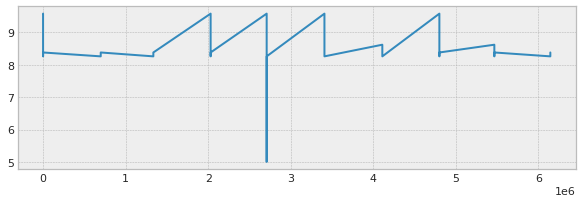

In [21]:
sellp[sellp["item_id"] == "HOBBIES_1_001"]["sell_price"].plot()

特徴量の生成
（移動平均をここに入れる）

LightGBMをここで回す

In [99]:
# going to evaluate with the last 28 days
x_train = data[data['date'] <= '2016-03-27']
y_train = x_train['demand']
x_val = data[(data['date'] > '2016-03-27') & (data['date'] <= '2016-04-24')]
y_val = x_val['demand']
test = data[(data['date'] > '2016-04-24')]

In [100]:
# もうちょっとスマートに書けるはず
categorical_features = [
    "item_id", 
    "dept_id", 
    "cat_id",
    "store_id",
    "state_id",
    "event_name_1",
    "event_type_1",
    "event_name_2",
    "event_type_2"]

x_train[categorical_features] = x_train[categorical_features].fillna("0")

other_features = ["demand", "snap_CA", "snap_TX", "snap_WI", "sell_price"]

x_train[other_features] = x_train[other_features].fillna(0)

In [101]:
x_train = ed.encode_categorical(x_train, categorical_features)

In [102]:
x_train

,id,item_id,dept_id,cat_id,store_id,state_id,demand,part,date,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,NaN,2011-01-29,11101.0,0,0,0,0,0.0,0.0,0.0,0.00
1,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,0,NaN,2011-01-29,11101.0,0,0,0,0,0.0,0.0,0.0,0.00
2,HOBBIES_1_003_CA_1_validation,2,0,0,0,0,0,NaN,2011-01-29,11101.0,0,0,0,0,0.0,0.0,0.0,0.00
3,HOBBIES_1_004_CA_1_validation,3,0,0,0,0,0,NaN,2011-01-29,11101.0,0,0,0,0,0.0,0.0,0.0,0.00
4,HOBBIES_1_005_CA_1_validation,4,0,0,0,0,0,NaN,2011-01-29,11101.0,0,0,0,0,0.0,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188495,HOBBIES_1_099_CA_1_validation,95,0,0,0,0,2,NaN,2016-03-27,11609.0,5,1,0,0,0.0,0.0,0.0,13.98
188496,HOBBIES_1_100_CA_1_validation,96,0,0,0,0,1,NaN,2016-03-27,11609.0,5,1,0,0,0.0,0.0,0.0,11.28
188497,HOBBIES_1_102_CA_1_validation,97,0,0,0,0,0,NaN,2016-03-27,11609.0,5,1,0,0,0.0,0.0,0.0,4.98
188498,HOBBIES_1_103_CA_1_validation,98,0,0,0,0,2,NaN,2016-03-27,11609.0,5,1,0,0,0.0,0.0,0.0,0.70


In [103]:
x_train = x_train.drop(["id", "part", "date"], axis = 1).astype("float64")

In [104]:
import lightgbm as lgb

In [105]:
# define random hyperparammeters for LGBM
features = [
    "item_id",
    "dept_id",
    "cat_id",
    "store_id",
    "state_id",
    "event_name_1",
    "event_type_1",
    "event_name_2",
    "event_type_2",
    "snap_CA",
    "snap_TX",
    "snap_WI",
    "sell_price",
    # # demand features.
    # "shift_t28",
    # "shift_t29",
    # "shift_t30",
    # "rolling_mean_t7",
    # "rolling_mean_t30",
    # "rolling_mean_t60",
    # "rolling_mean_t90",
    # "rolling_mean_t180",
    # # price features
    # "price_change_t1",
    # "price_change_t365",
    # "rolling_price_std_t7",
    # "rolling_price_std_t30",
    # # time features.
    # "year",
    # "month",
    # "week",
    # "day",
    # "dayofweek",
    # "is_year_end",
    # "is_year_start",
    # "is_quarter_end",
    # "is_quarter_start",
    # "is_month_end",
    # "is_month_start",
    # "is_weekend",
]

params = {
    'boosting_type': 'gbdt',
    'metric': 'rmse',
    'objective': 'regression',
    'n_jobs': -1,
    'seed': 236,
    'learning_rate': 0.1,
    'bagging_fraction': 0.75,
    'bagging_freq': 10, 
    'colsample_bytree': 0.75}

train_set = lgb.Dataset(x_train[features], y_train)
val_set = lgb.Dataset(x_val[features], y_val)

#del x_train, y_train

In [106]:
# model estimation
model = lgb.train(params, train_set, num_boost_round = 2500, early_stopping_rounds = 50, valid_sets = [train_set, val_set], verbose_eval = 100)

ValueError: ignored

In [109]:
x_train["dept_id"].unique()

array([0.])

In [ ]:
val_pred = model.predict(x_val[features])
val_score = np.sqrt(metrics.mean_squared_error(val_pred, y_val))
print(f'Our val rmse score is {val_score}')
y_pred = model.predict(test[features])
test['demand'] = y_pred

In [10]:
%autoreload

In [11]:
!pwd

/content/drive/My Drive/kaggle/module


In [12]:
# Lstv = ed.encode_categorical(stv, cols = ["dept_id", "cat_id", "store_id", "state_id"])

In [13]:
stv.head(10)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,...,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4
5,HOBBIES_1_006_CA_1_validation,HOBBIES_1_006,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,0,1,0,0,1,4,0,0,0,1,0,1,0,0,0,2,0,0
6,HOBBIES_1_007_CA_1_validation,HOBBIES_1_007,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,1,1
7,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,12,15,0,0,0,4,6,5,7,0,13,2,2,20,9,3,0,1,0,...,2,12,38,22,2,0,10,26,8,12,4,5,2,8,4,0,0,1,37,3,4,6,3,2,1
8,HOBBIES_1_009_CA_1_validation,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,2,0,7,3,0,2,3,9,0,0,4,3,1,0,4,4,1,2,0,...,1,2,0,3,0,0,0,0,0,1,1,0,7,0,0,0,0,1,1,6,0,0,0,0,0
9,HOBBIES_1_010_CA_1_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,2,...,1,1,0,3,2,2,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,2,0,2


In [23]:
c = stv["id"].value_counts()
c[c != 1]

Series([], Name: id, dtype: int64)

In [15]:
stv.shape

(30490, 1919)

In [ ]:
nrows = 365 * 2 * NUM_ITEMS

In [ ]:
stv.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,...,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4


In [ ]:
stv.drop("")

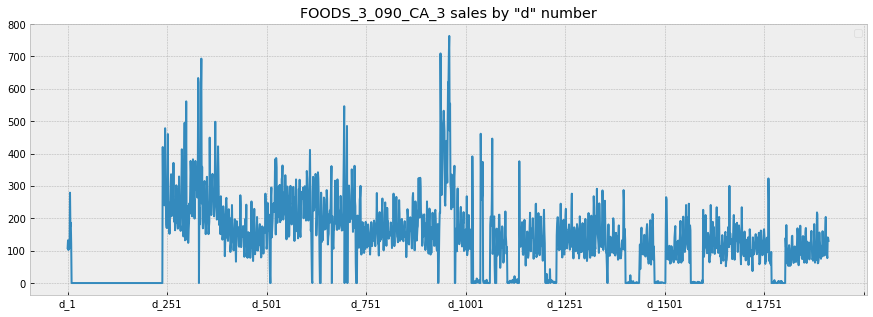

In [ ]:
d_cols = [c for c in stv.columns if 'd_' in c]
stv.loc[stv['id'] == 'FOODS_3_090_CA_3_validation'] \
    .set_index('id')[d_cols] \
    .T \
    .plot(figsize=(15, 5),
          title='FOODS_3_090_CA_3 sales by "d" number',
          color=next(color_cycle))
plt.legend('')
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder

def transform(data):
    
    nan_features = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
    for feature in nan_features:
        data[feature].fillna('unknown', inplace = True)
        
    cat = ['event_name_1','event_type_1','event_name_2','event_type_2','snap_CA','snap_TX','snap_WI']
    for feature in cat:
        encoder = LabelEncoder()
        data[feature] = encoder.fit_transform(data[feature])
    
    return data
#calendarの何もない日をunknownで埋めて、label encoderによって処理しやすい形に変える
# one-hot encodingのほうが良いのでは？

In [ ]:
from sklearn import preprocessing, metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Dropout
from keras.layers import RepeatVector,TimeDistributed, BatchNormalization
from numpy import array
from keras.models import Sequential, load_model
from keras.optimizers import Adam, RMSprop
#import utils_paths
import re
from tqdm import tqdm
import os

"""
仮のモデル
ハイパーパラメータを引数にとれるよう改造すべき？
※ チューニングができるように
"""
def build_model(lstm_unit = 128, timesteps = 28, delay = 1, n_out_seq_length = 28, num_y = 1, repeat_vector = 28):
    train_generator = train_data_from_csv_generator(num=1) 
    x_shape = next(train_generator).shape
    len_sequence, num_features = x_shape

    model = Sequential()

    model.add(LSTM(lstm_unit, activation='relu', batch_input_shape=(None, timesteps, num_features), return_sequences=False))
    model.add(BatchNormalization())
    model.add(RepeatVector(repeat_vector))
    model.add(LSTM(32, activation='relu', return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))  
    model.add(TimeDistributed(Dense(delay, activation="relu")))   # num_y means the shape of y,in some problem(like translate), it can be many.
                                                #In that case, you should set the  activation= 'softmax'
    
    #RMSpropOptimizer = RMSprop(lr=0.001, clipvalue=0.5)
    #model.compile(optimizer=RMSpropOptimizer, loss='mean_squared_error', metrics=["accuracy"])
    model.compile(optimizer="adam", loss='mean_squared_error', metrics=["accuracy"])


    return model

Using TensorFlow backend.


In [ ]:
model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               73216     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 28, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 28, 32)            20608     
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 32)            128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 32)            0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 28, 1)            

In [ ]:
from keras.utils import Sequence
from keras.models import Sequential

"""
model.fit_generatorを使うためのユーザ定義関数
※ generator を使わないとメモリが死ぬ
"""
class ReccurentTrainGenerator(Sequence):
    def _resetindices(self):
        """
        バッチ生成用のインデックスをランダムに出力
        """
        self.num_called = 0

        all_idx = np.random.permutation(np.arange(self.num_batches))
        remain_idx = np.random.choice(np.arange(self.num_batches),
                                      size=(self.steps_per_epoch*self.batch_size-len(all_idx)),
                                      replace=False)
        
        self.indices = np.hstack([all_idx, remain_idx]).reshape(self.steps_per_epoch, self.batch_size)

    def __init__(self, InputTensor, batch_size, InputSteps=28, OutputSteps=28, delay=1, normalize_factor=None):
        """
        【入力】
        InputTensor: 入力データ(説明変数) データ数("HOBBIES_1_..."などに対応) × データ点数(時系列方向のデータ数) × 特徴量数 のndarray
                     ※ 正解ラベルも、この時系列データからとるのでこれだけ入力すればOK 
        batch_size: バッチサイズ(例えば、timestepが5として、時刻0~4までのデータ、1~5までのデータ、...、10~14までのデータ、
                                をひとまとめにして1データとみなすとする。RNNの場合はこのサイズがバッチサイズに対応する。)
        InputSteps: リカレント層に食わせるデータを、何ステップ前までのデータにするか
        OutputSteps: リカレント層からの出力(予測ステップ数)の設定値
        delay: 目的変数をどの程度遅らせるか？(予測ステップのスタート位置をどの程度後ろにずらすか)
        normalize_factor: 正規化する際のスケーリングをどの程度にするか
        """
        self.train_tensor = InputTensor 

        # 各種パラメータ
        self.num_datas = InputTensor.shape[0]
        self.len_sequence = InputTensor.shape[1]
        self.num_features = InputTensor.shape[2]
        self.batch_size = batch_size
        self.input_steps = InputSteps
        self.output_steps = OutputSteps
        self.delay = delay

        # 現在のエポックでバッチ生成の対象となっているデータ系列
        self.now_data = InputTensor[0]

        # 各データ系列に対し、バッチサイズいくつ作れるか計算するのに必要な値
        self.len_requied_per_batch = InputSteps + (batch_size-1) + (delay-1) + OutputSteps # 訓練データと正解データを作るために必要なサイズ 
        self.num_batches = self.len_sequence - self.len_requied_per_batch + 1              # 作れるバッチの数

        # 1エポック当たりのステップ数
        self.steps_per_epoch = int(np.ceil(self.len_sequence / float(batch_size)))
        
        # バッチ生成用の乱数初期化
        self._resetindices()

        # データ取得用インデックス生成
        self.data_idx = self._reset_dataset_indices(self.num_datas)
        self.num_epoch = 0

        self.normalize_factor = normalize_factor


    def __len__(self):
        """
        1エポックあたりのステップ数をリターン
        """
        return self.steps_per_epoch

    def __getitem__(self, idx):
        """
        データをバッチにまとめて出力
        """
        indices_temp = self.indices[idx] # indices は (steps_per_epoch, batchsize)の array

        batch_x = np.array([self.now_data[i:i+self.input_steps] for i in indices_temp])
        batch_y = np.array([self.now_data[i+self.input_steps+(self.delay-1):i+self.input_steps+(self.delay-1)+self.output_steps, -1] for i in indices_temp]).reshape(self.batch_size, self.output_steps, 1)

        if self.num_called == (self.steps_per_epoch-1):
            self._resetindices()
        else:
            self.num_called += 1

        if self.normalize_factor:
            batch_x = batch_x / self.normalize_factor
            batch_y = batch_y / self.normalize_factor

        return batch_x, batch_y

    def on_epoch_end(self):
        """
        Epoch 終了ごとにデータセットを入れ替える
        (データセット："HOBBIES_1_..."などに対応)
        """
        if self.num_epoch == self.num_datas:
            self.num_epoch = 0
            self.data_idx = self._reset_dataset_indices(self.num_datas)
        else:
            self.num_epoch += 1
        
        next_data_idx = self.data_idx[self.num_epoch]
        self.now_data = self.train_tensor[next_data_idx]


    def _reset_dataset_indices(self, num_datas):
        """
        Epoch毎に入れ替えるデータのインデックスをランダムにするためのメソッド
        """
        return np.random.permutation(np.arange(num_datas))

In [ ]:
"""
Generatorに食わせるためのトレーニングデータ(ndarray)作成関数
一度作って np.saveで保存すれば使う必要なし(この関数の実行は時間かかる)
"""
def CreateTrainingTensor(num=30490):
    tg = train_data_from_csv_generator(num=1)
    shape = next(tg).shape
    X_train = np.zeros((num, shape[0], shape[1]))

    train_generator = train_data_from_csv_generator(num=num)

    for i, array in enumerate(train_generator):
        if i/1000 == i//1000:
            print(i)

        X_train[i] = array

    return X_train

In [ ]:
# 作成と保存の例
# X_train = CreateTrainingTensor()
# X_train = CreateTrainingTensor()

In [ ]:
# 読みだしは基本こっちで
X_train = np.load(INPUT_DIR + "/TrainingTensor.npy")

In [ ]:
X_max = np.max(X_train)

RTG = ReccurentTrainGenerator(InputTensor=X_train[:-100], batch_size=128, InputSteps=28, normalize_factor=X_max)
Validation_RTG = ReccurentTrainGenerator(X_train[:-100], batch_size=128, InputSteps=28, normalize_factor=X_max)
# トレーニングデータの一部をバリデーション用にする

In [ ]:
from keras.callbacks import EarlyStopping 
 
# Early-stopping: patienceはもう少し大きくとる？
early_stopping = EarlyStopping(patience=5, verbose=1) 

history = model.fit_generator(RTG, epochs=500, verbose=1, validation_data=Validation_RTG, callbacks=[early_stopping])

Epoch 1/500
16/16 [==============================] - 4s 278ms/step - loss: 5.2515e-04 - accuracy: 0.6719 - val_loss: 3.5139e-08 - val_accuracy: 0.6721
Epoch 2/500
16/16 [==============================] - 3s 170ms/step - loss: 1.3748e-06 - accuracy: 0.6720 - val_loss: 3.5619e-08 - val_accuracy: 0.6717
Epoch 3/500
16/16 [==============================] - 3s 171ms/step - loss: 6.1179e-07 - accuracy: 0.6719 - val_loss: 3.5379e-08 - val_accuracy: 0.6718
Epoch 4/500
16/16 [==============================] - 3s 171ms/step - loss: 3.2946e-07 - accuracy: 0.6718 - val_loss: 3.5109e-08 - val_accuracy: 0.6719
Epoch 5/500
16/16 [==============================] - 3s 171ms/step - loss: 1.0600e-07 - accuracy: 0.6721 - val_loss: 3.5860e-08 - val_accuracy: 0.6719
Epoch 6/500
16/16 [==============================] - 3s 181ms/step - loss: 4.2529e-06 - accuracy: 0.6718 - val_loss: 3.5229e-08 - val_accuracy: 0.6719
Epoch 7/500
16/16 [==============================] - 3s 175ms/step - loss: 2.3316e-07 - accura

In [ ]:
# 学習結果の保存
model_json_str = model.to_json()
open('LSTM_test_model.json', 'w').write(model_json_str)
model.save_weights('LSTM_test_weights.h5');

In [ ]:
"""
提出用データの入力作成関数
(これも結果をnp.saveで保存してしまえば使う必要なし)
"""
def GenerateInputForPrediction(num_samples=30490):
    TIMESTEPS = 28

    train_generator = train_data_from_csv_generator(num=1) 
    x_shape = next(train_generator).shape
    num_features = x_shape[1]

    #X_test = np.zeros((num_samples, TIMESTEPS, num_features))

    train_generator = train_data_from_csv_generator(num=num_samples)

    for i, array in enumerate(train_generator):
        #X_test[i] = array[-TIMESTEPS:]
        yield array[-TIMESTEPS:]

In [ ]:
# テストデータ作成と保存

# X_test_generator = GenerateInputForPrediction()
# X_test = np.zeros((30490, 28, 14))
# for i, array in enumerate(X_test_generator):
#     if i / 1000 == i //1000:
#         print(i)
#     X_test[i] = array 
# np.save(INPUT_DIR + "/test_data.npy", X_test)

In [ ]:
# テストデータの読み出し
X_test = np.load(INPUT_DIR + "/test_data.npy")

In [ ]:
prediction = model.predict(X_test)

In [ ]:
"""
予測結果のndarrayを提出形式のcsvに変換する関数
"""

INPUT_DIR = "./drive/My Drive/kaggle/m5-forecasting/datas"

def CreateSubmissionCSV(prediction, save_path=INPUT_DIR):
    # Create Prediction DataFrame
    prediction = np.rint(prediction)
    prediction = prediction.astype("int")
    pred_df = pd.DataFrame(prediction.reshape(30490, 28))

    # Get "id" columns (id の情報だけまとめたファイルを作成した方が軽いはず -> 未実装)
    stv = pd.read_csv(INPUT_DIR + "/sales_train_validation.csv")
    ste = pd.read_csv(INPUT_DIR + "/sales_train_evaluation.csv")

    # Rename Index & Columns
    pred_df.index = list(ste["id"])
    pred_df.columns = [f'F{i}' for i in range(1, 28 + 1)]

    # Set index label "id"
    pred_df = pred_df.reset_index()
    pred_df = pred_df.rename(columns={"index": "id"})
    pred_df = pred_df.set_index("id")

    # Create "Validation" DataFrame
    validation_df = ste[["id"] +  ["d_" + str(i) for i in range(1914, 1942)]]

    # Rename columns & set index "id"
    validation_df = validation_df.set_index("id")
    validation_df = validation_df.rename(columns={"d_" + str(i + 1913): "F" + str(i) for i in range(1, 29)})
    validation_df.index = stv["id"]

    # Create Submission DataFrame (shape = (60980, 28))
    submission_df = pd.concat([validation_df, pred_df], axis=0)
    submission_df.to_csv(save_path + "/submission.csv")

    # For Debug

    print(submission_df.shape)
    return submission_df


In [ ]:
X_test_max = np.max(X_test)
sub_df = CreateSubmissionCSV(prediction / X_test_max)

(60980, 28)


In [ ]:
sub_df

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
HOBBIES_1_001_CA_1_validation,0,0,0,2,0,3,5,0,0,1,1,0,2,1,2,2,1,0,2,4,0,0,0,0,3,3,0,1
HOBBIES_1_002_CA_1_validation,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,2,1,1,0,0,0,0,0
HOBBIES_1_003_CA_1_validation,0,0,1,1,0,2,1,0,0,0,0,2,1,3,0,0,1,0,1,0,2,0,0,0,2,3,0,1
HOBBIES_1_004_CA_1_validation,0,0,1,2,4,1,6,4,0,0,0,2,2,4,2,1,1,1,1,1,0,4,0,1,3,0,2,6
HOBBIES_1_005_CA_1_validation,1,0,2,3,1,0,3,2,3,1,1,3,2,3,2,2,2,2,0,0,0,2,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FOODS_3_823_WI_3_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,4,0
FOODS_3_824_WI_3_evaluation,0,0,0,0,0,0,0,0,0,2,4,7,9,11,13,15,13,0,6,0,20,22,22,22,22,22,23,23
FOODS_3_825_WI_3_evaluation,0,1,1,0,0,0,0,0,0,0,0,0,0,1,2,4,4,4,4,4,4,4,4,4,4,4,4,4


# クロスバリデーションのためのテスト

In [ ]:
# データ読み出し
X_train = np.load(INPUT_DIR + "/TrainingTensor.npy")

In [ ]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5)
CV_gen = kfold.split(X_train[:1000])

In [ ]:
next(CV_gen)[0].shape

(800,)

In [ ]:
from keras.callbacks import EarlyStopping 

History = []

# 1000サンプルでクロスバリデーションテスト
for train_cv_idx, valid_cv_idx in kfold.split(X_train[:1000]):
    X_CV_train_gen = ReccurentTrainGenerator(X_train[train_cv_idx], batch_size=128)
    X_CV_valid_gen = ReccurentTrainGenerator(X_train[valid_cv_idx], batch_size=128)

    model = build_model() #カテゴリごとのモデルを作る時も、同様にfor文内で再度モデルをビルドすればよいかもしれない。
 
    # Early-stopping: patienceはもう少し大きくとる？
    early_stopping = EarlyStopping(patience=5, verbose=1) 

    history = model.fit_generator(X_CV_train_gen, epochs=500, verbose=1, validation_data=X_CV_valid_gen, callbacks=[early_stopping])
    History.append(history)

Epoch 1/500
16/16 [==============================] - 4s 272ms/step - loss: 0.4942 - accuracy: 0.5703 - val_loss: 12.5325 - val_accuracy: 0.4849
Epoch 2/500
16/16 [==============================] - 3s 170ms/step - loss: 0.3649 - accuracy: 0.6107 - val_loss: 0.3896 - val_accuracy: 0.6683
Epoch 3/500
16/16 [==============================] - 3s 169ms/step - loss: 0.3396 - accuracy: 0.6123 - val_loss: 553.0335 - val_accuracy: 0.6341
Epoch 4/500
16/16 [==============================] - 3s 170ms/step - loss: 0.3302 - accuracy: 0.6275 - val_loss: 0.7468 - val_accuracy: 0.6242
Epoch 5/500
16/16 [==============================] - 3s 169ms/step - loss: 0.3171 - accuracy: 0.6379 - val_loss: 0.3511 - val_accuracy: 0.6716
Epoch 6/500
16/16 [==============================] - 3s 168ms/step - loss: 0.3155 - accuracy: 0.6313 - val_loss: 0.7788 - val_accuracy: 0.6646
Epoch 7/500
16/16 [==============================] - 3s 170ms/step - loss: 0.3047 - accuracy: 0.6464 - val_loss: 0.3733 - val_accuracy: 0.6

In [ ]:
History

In [ ]:
History[0].history

{'accuracy': [0.57034737,
  0.6107003,
  0.6122872,
  0.62749374,
  0.637922,
  0.63126045,
  0.64643204,
  0.64556015,
  0.6120257,
  0.62276787,
  0.6492745,
  0.6417411,
  0.6265869,
  0.6461007,
  0.64624023,
  0.6397182,
  0.6143624],
 'loss': [0.494242025539279,
  0.36485074646770954,
  0.3396125864237547,
  0.3301929496228695,
  0.31714816577732563,
  0.31546652875840664,
  0.3046710081398487,
  0.3033412732183933,
  0.3161908984184265,
  0.3191160410642624,
  0.2881226111203432,
  0.28610892593860626,
  0.30391204357147217,
  0.27669483609497547,
  0.28784034959971905,
  0.2746207006275654,
  0.26982585340738297],
 'val_accuracy': [0.48486328125,
  0.6683174967765808,
  0.6340680718421936,
  0.6241978406906128,
  0.6715959906578064,
  0.6645682454109192,
  0.6095145344734192,
  0.6722237467765808,
  0.6717005968093872,
  0.6721714735031128,
  0.6718401312828064,
  0.6717005968093872,
  0.6723109483718872,
  0.6720842719078064,
  0.6724156141281128,
  0.67236328125,
  0.67168319

In [ ]:
History[0].history["val_loss"]

[12.532462120056152,
 0.389602929353714,
 553.0335083007812,
 0.7467711567878723,
 0.3511177599430084,
 0.7788005471229553,
 0.3732623755931854,
 0.3270089328289032,
 0.330556184053421,
 0.29370221495628357,
 0.29070037603378296,
 0.290618360042572,
 0.316451758146286,
 0.3174732029438019,
 0.3239397406578064,
 0.3256138265132904,
 0.32973018288612366]

In [ ]:
def objective(hyperparameters, iteration):
    """Objective function for grid and random search. Returns
       the cross validation score from a set of hyperparameters."""
    # Number of estimators will be found using early stopping
    if 'n_estimators' in hyperparameters.keys():
        del hyperparameters['n_estimators']
     # Perform n_folds cross validation
    cv_results = lgb.cv(hyperparameters, train_set, num_boost_round = 10000, nfold = N_FOLDS, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 42)
    # results to retun
    score = cv_results['auc-mean'][-1]
    estimators = len(cv_results['auc-mean'])
    hyperparameters['n_estimators'] = estimators 
    return [score, hyperparameters, iteration]

In [ ]:
from sklearn.model_selection import KFold

def objective(hyperparameters, X_train):
    """
    hyperparameters:
    LSTM units
    LSTM activation

    # ハイパーパラメータは、build_modelの引数に渡す。
    後ほど実装。(今は引数なし)

    """
    batch_size = 128
    epochs = 500

    
    kfold = KFold(n_splits=5)
    History = []

    for train_cv_idx, valid_cv_idx in kfold.split(X_train):

        X_CV_train_gen = ReccurentTrainGenerator(X_train[train_cv_idx], batch_size=batch_size)
        X_CV_valid_gen = ReccurentTrainGenerator(X_train[valid_cv_idx], batch_size=batch_size)

        model = build_model() # 引数にハイパーパラメータを入れられるようにする

        early_stopping = EarlyStopping(patience=5, verbose=1) 

        history = model.fit_generator(X_CV_train_gen, epochs=epochs, verbose=1, validation_data=X_CV_valid_gen, callbacks=[early_stopping])
        History.append(history)

    scores = [History[i].history["val_loss"][-1] for i in range(len(History))]
    mean_score = np.mean(scores)

    return mean_score

In [ ]:
import pandas as pd
import random
random.seed(50)

def random_search(param_grid, max_evals):
    """Random search for hyperparameter optimization"""
    
    # Dataframe for results
    results = pd.DataFrame(columns = ['score', 'params'], index = list(range(max_evals)))
    
    # Keep searching until reach max evaluations
    for i in range(max_evals):
        # Choose random hyperparameters
        hyperparameters = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}

        # Evaluate randomly selected hyperparameters
        score = objective(hyperparameters)
        results.loc[i, :] = [score, hyperparameters]

    # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    return results 

def objective(hyperparameters):
    """Objective function for grid and random search. Returns
       the cross validation score from a set of hyperparameters."""
    
    # Perform n_folds cross validation
    # cv_results = hoge(hyperparameters, train_set, num_boost_round = 10000, nfold = N_FOLDS, 
    #                    early_stopping_rounds = 100, metrics = 'auc', seed = 42)
    # score = cv_results['auc-mean'][-1]
    
    score = 10
    #score = hoge(hyperparameters)
    
    return score


lstm_unit = 128, timesteps = 28, delay = 1, n_out_seq_length = 28, num_y = 1, repeat_vector = 28

param_grid = {
    "lstm_unit" : list(range(100, 200, 50)), 
    "timesteps" : [28],
    "delay" : [1],
    "n_out_seq_length" : [28],
    "num_y" : [1],
    "repeat_vector" : list(range(7, 56, 7)),
}

In [ ]:
mean_score = objective("hyperparameters", X_train[:1000])

Epoch 1/500
16/16 [==============================] - 4s 245ms/step - loss: 0.4873 - accuracy: 0.5721 - val_loss: 2.4192 - val_accuracy: 0.6165
Epoch 2/500
16/16 [==============================] - 3s 171ms/step - loss: 0.3866 - accuracy: 0.5984 - val_loss: 6.4519 - val_accuracy: 0.5566
Epoch 3/500
16/16 [==============================] - 3s 173ms/step - loss: 0.3658 - accuracy: 0.6076 - val_loss: 0.3284 - val_accuracy: 0.6708
Epoch 4/500
16/16 [==============================] - 3s 174ms/step - loss: 0.3135 - accuracy: 0.6369 - val_loss: 13.5748 - val_accuracy: 0.6592
Epoch 5/500
16/16 [==============================] - 3s 170ms/step - loss: 0.3102 - accuracy: 0.6405 - val_loss: 9.2438 - val_accuracy: 0.6471
Epoch 6/500
16/16 [==============================] - 3s 172ms/step - loss: 0.3023 - accuracy: 0.6500 - val_loss: 0.3998 - val_accuracy: 0.6643
Epoch 7/500
16/16 [==============================] - 3s 174ms/step - loss: 0.3018 - accuracy: 0.6486 - val_loss: 13.7566 - val_accuracy: 0.29

In [ ]:
mean_score

5.3194280624389645

# Loss を自作する(RMSSEをLossとして学習する)